<a href="https://colab.research.google.com/github/jacomyma/dtu-sts-material/blob/main/notebooks/colab/Query_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Query examples

*DTU - Explore the Energy Islands controversy*

**Goal**:
- Look at how queries are constructed to learn how to make your own

**How to use**:
- **You may just look at the commented examples without running anything**
- Or you may run and possibly modify the notebook
  - Use "Runtime > Run all" or execute from the edited cell and below
  - Wait for each cell to run
  - ⚠️ Allow the script to access your Google Drive data when prompted to


## Prep code

(You don't have to understand what's going on in this part, but feel free to take a look)

In [ ]:
# File URL
settings = {}
settings['statements_spreadsheet_drive_URL'] = 'https://docs.google.com/spreadsheets/d/1cSwVVXAB7kYRbGKEr6gc5IGs955dIfJNcCzyl_cywa8/edit?usp=drive_link'

In [ ]:
# Install stuff
!pip install pandas gspread google-auth google-auth-oauthlib google-auth-httplib2

In [ ]:
# Import necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
# Open the spreadsheet by its key or URL
spreadsheet_key = settings['statements_spreadsheet_drive_URL'].split('/d/')[1].split('/edit')[0]
sh = gc.open_by_key(spreadsheet_key)

# Select the worksheet
worksheet_name = 'dataset'
worksheet = sh.worksheet(worksheet_name)

In [ ]:
# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Create a Pandas DataFrame from the list of lists
df = pd.DataFrame(data[1:], columns=data[0])

# Set 'Year' column to int
df['Year'] = df['Year'].replace('', pd.NA)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(pd.Int64Dtype())

# Set 'X', 'Y' and 'Size' columns to float
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

print('Data loaded.')

Data loaded.


In [ ]:
# This is the function we will use to visualize a matching condition
def visualize(condition, title='Proportion of filtered items'):
  # Make a copy of df
  df_copy = df.copy()

  # Mark each row of df_copy as filtered if the condition is fulfilled
  df_copy['filtered'] = condition

  # Plot a pie chart with counts and percentages
  filtered_counts = df_copy['filtered'].value_counts()

  def make_autopct(values):
      def my_autopct(pct):
          total = sum(values)
          val = int(round(pct*total/100.0))
          return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
      return my_autopct

  # Define the colors for True and False
  colors = ['#4deded' if label else '#EAEAEA' for label in filtered_counts.index]

  # Create a figure with a small size
  plt.figure(figsize=(3, 3))

  plt.pie(filtered_counts, autopct=make_autopct(filtered_counts), colors=colors, startangle=90)
  plt.title(title)
  plt.show()

# Columns available
Copy-paste from this list the exact name of columns to build your queries.

In [ ]:
# List columns available
print("COLUMNS:")
print("\n".join(df.columns))

COLUMNS:
id
Statement
Actor
Representative of
Actor context
Year
Date of publication
Source URL
Source name
Source type
Cluster
Issue_1
Issue_2
Issue_3
Issue_4
Issue_5
Issue_6
Issue_7
Issue_8
Issue_9
Issue_10
Issue_11
Issue_12
Issue_13
Issue_14
Issue_15
Issue_16
X
Y
Size


# Query examples

## Simple text query

In this example, the condition is simply that the column "Statement" contains the expression "Bornholm".

```df``` is the "dataframe", i.e. the dataset.

⚠️ Beware, this query is case-sensitive.

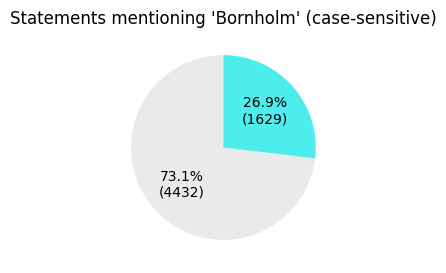

In [ ]:
condition = df['Statement'].str.contains('Bornholm', na=False)

visualize(condition, "Statements mentioning 'Bornholm' (case-sensitive)")

Note: the part ```na=False``` means that if a cell is empty or an error ("na" stands for "not available"), then the match should count as False.

As this query is case-sensitive, which is sometimes what you want but not all the time, if you search for "bornholm" you will find (almost) zero results.

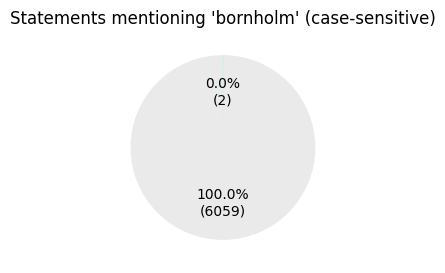

In [ ]:
condition = df['Statement'].str.contains('bornholm', na=False)

visualize(condition, "Statements mentioning 'bornholm' (case-sensitive)")

The solution is to add a parameter to specify that the query must be case-insensitive.

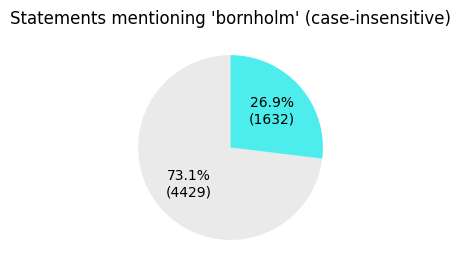

In [ ]:
condition = df['Statement'].str.contains('bornholm', case=False, na=False)

visualize(condition, "Statements mentioning 'bornholm' (case-insensitive)")

Note: this way of searching also finds the query if it is part of a word. See the example below with "Bornholm" without the first and last letter.

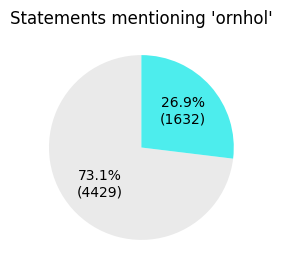

In [ ]:
condition = df['Statement'].str.contains('ornhol', case=False, na=False)

visualize(condition, "Statements mentioning 'ornhol'")

## Advanced text query

You can search for one or more terms at the same time with the operator "|" (pronounced "pipe") within the query itself. It acts like a "OR" operator in search engines.

*Note: you cannot do the "AND" operation that way (see how to combine queries down below).*

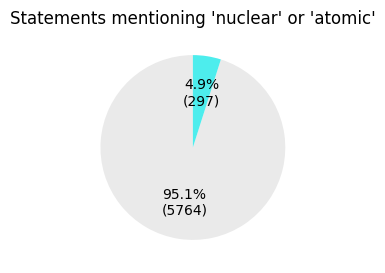

In [ ]:
condition = df['Statement'].str.contains('nuclear|atomic', case=False, na=False)

visualize(condition, "Statements mentioning 'nuclear' or 'atomic'")

You can also search using **regular expressions**, if you know how these work, by adding the parameter ```regex=True```

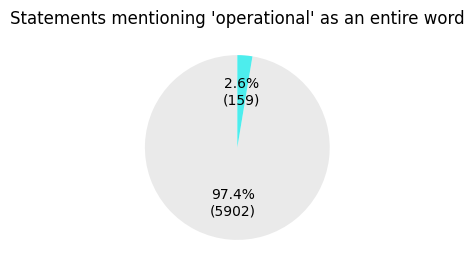

In [ ]:
# Regex that finds the expression "operational" but only if it is a word, i.e. not surrounded by any letter.
# This will for instance omit "operationalize". But regular expressions can do many other things.
regex = r'\boperational\b'
condition = df['Statement'].str.contains(regex, case=False, na=False, regex=True)

visualize(condition, "Statements mentioning 'operational' as an entire word")

## Number queries



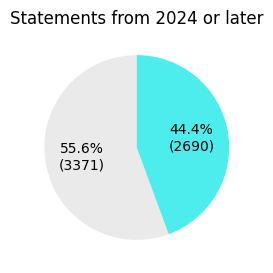

In [ ]:
condition = df['Year'] >= 2024

visualize(condition, "Statements from 2024 or later")

## Exact match queries

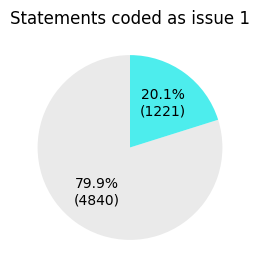

In [ ]:
condition = df['Issue_1'] == "TRUE"

visualize(condition, "Statements coded as issue 1")

## Get the modalities

Do do exact match queries, you need to know what modalities the variable can take (or in other words, what different values you can find in the column). You can have this information with the code below.

In [ ]:
# Get the 5 modalities the most represented in column "Source type"
df['Source type'].value_counts().head(5)

,count
Source type,
National newspaper,1948
Social media,1932
Research paper,528
Company website,315
Governmental report,256


Now we can copy-paste one of those values to use it in a query.

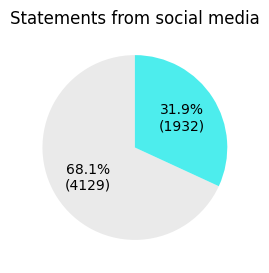

In [ ]:
condition = df['Source type'] == "Social media"

visualize(condition, "Statements from social media")

## Combine queries

You can combine multiple conditions into one using operators like "&" (AND) and "|" (OR).

In [ ]:
condition1 = df['Statement'].str.contains('Bornholm', case=False, na=False)
condition2 = df['Source type'] == "Social media"
condition = condition1 & condition2

visualize(condition, "Statements mentioning 'Bornholm' AND from social media")

NameError: name 'df' is not defined

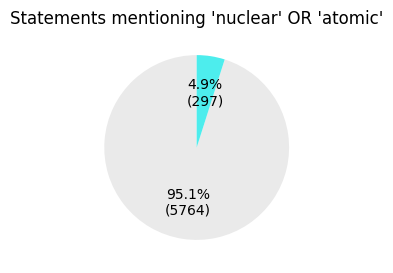

In [ ]:
condition1 = df['Statement'].str.contains('nuclear', case=False, na=False)
condition2 = df['Statement'].str.contains('atomic', case=False, na=False)
condition = condition1 | condition2

visualize(condition, "Statements mentioning 'nuclear' OR 'atomic'")

You can chain the conditions directly in the code and you're allowed to skip lines, but you must wrap the conditions in parentheses as in the example below.

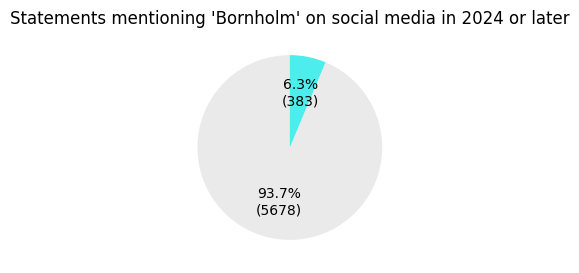

In [ ]:
condition = (
    (df['Statement'].str.contains('Bornholm', case=False, na=False))
  & (df['Source type'] == "Social media")
  & (df['Year'] >= 2024)
)

visualize(condition, "Statements mentioning 'Bornholm' on social media in 2024 or later")

You can also mix and match AND and OR clauses but then you need to use parentheses strategically to tell explicitly where the priority lies.

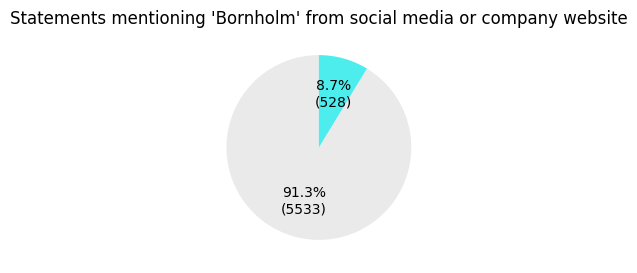

In [ ]:
condition = (
    (df['Statement'].str.contains('Bornholm', case=False, na=False))
  & (
        (df['Source type'] == "Social media")
      | (df['Source type'] == "Company website")
    )
  )

visualize(condition, "Statements mentioning 'Bornholm' from social media or company website")